# CC5215: Privacidad de Datos

## Laboratorio 10

Integrantes: (trabajé solo porque no pude conseguir equipo de trabajo)

- Nombre: Diego Espinoza

In [1]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt


def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')

## Preamble

In this lab we are going to experiment with more advanced variants of differential privacy. These advanced variants are based on specific statistics concepts and as we will see, they will allow us to compose private results with tighter bounds. Finally, we will implement the noisy gradient descent algorithm seen in class, but with different variants of DP.

## Question 1 (4 points)

Look at the two graphs:

- What information is presented in each plot?
- What can you say about sequential composition for $\epsilon$-DP? what about $(\epsilon, \delta)$-DP?

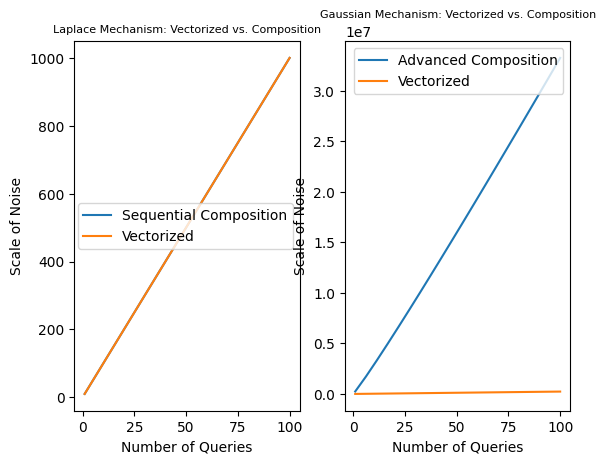

In [2]:
ks = np.linspace(1, 100, 20)


## (epsilon)

epsilon = .1

plt.subplot(1, 2, 1)

# L1 sensitivity of each query: 1
# noise per query: 1/epsilon
# number of queries: k
noises_seq_eps = [k*(1/epsilon) for k in ks]
plt.plot(ks, noises_seq_eps, label='Sequential Composition')

# number of queries: 1
# L1 sensitivity of each query: k
# noise per query: k / epsilon
noises_L1_eps = [1*(k/epsilon) for k in ks]
plt.plot(ks, noises_L1_eps, label='Vectorized')
plt.title('Laplace Mechanism: Vectorized vs. Composition', {
    'fontsize': 8
})
plt.xlabel('Number of Queries')
plt.ylabel('Scale of Noise')
plt.legend();

## (epsilon, delta)

epsilon = .1
delta = 1e-5

plt.subplot(1, 2, 2)

# L2 sensitivity of each query: 1
# number of queries: k
noises_seq_epsdel = [16*k*np.log((2.5*k)/delta)*np.log(2/delta)/(epsilon**2) for k in ks]
plt.plot(ks, noises_seq_epsdel, label='Advanced Composition')

# number of queries: 1
# L2 sensitivity of each query: sqrt(k)
noises_L1_epsdel = [2*k*np.log(1.25/delta)/(epsilon**2) for k in ks]
plt.title('Gaussian Mechanism: Vectorized vs. Composition', {
    'fontsize': 8,
})
plt.xlabel('Number of Queries')
plt.ylabel('Scale of Noise')
plt.plot(ks, noises_L1_epsdel, label='Vectorized')
plt.legend();

Look at the two graphs:

- What information is presented in each plot?

Ambos gráficos comparan dos formas diferentes de agregar ruido a las respuestas de múltiples consultas bajo distintos mecanismos de privacidad diferencial: el mecanismo de Laplace y el Gaussiano, según dos escenarios diferentes; la composición secuencial/composición avanzada (una consulta a la vez) vs el vectorizado (todas las consultas juntas como un vector)

En el gráfico de la izquierda se la escala del ruido en función del número de consultas para el mecanismo de Laplace. En particular, la línea naranja representa las consultas vectorizadas mientras que la línea azul la composición secuencial de las consultas. En este caso, ambos mecanismos son $\varepsilon$-DP (puros). El ruido es proporcional a la sensibilidad L1. Del gráfico podemos ver que el ruido no cambia si la consulta es vectorizada o si es individual.

En el gráfico de la derecha lo mismo, pero para el mecanismo Gaussiano, donde se puede ver que a medida que aumenta el número de consultas, el ruido de la composición avanzada crece más rapido en relación a la vectorizada. Ninguno de estos dos mecanismos garantiza $\varepsilon$-DP pura, solamente ($\varepsilon, \delta$)-DP, con $\delta$>0. 

Del gráfico podemos ver que el ruido agregado es menor para la consulta vectorizada, y por ende, la utilidad o cantidad de información es mayor para dichas consultas vectorizadas que para cuando aplicamos composición avanzada.

- What can you say about sequential composition for $\epsilon$-DP? what about $(\epsilon, \delta)$-DP?

Primero que todo, cuando hacemos varias consultas a una base de datos privada como lo es nuestro caso, y cada consulta respeta un mecanismo de privacidad diferencial, la privacidad total se degrada a medida que acumulamos más respuestas, porque más información conozco de la base de datos. 

Cuando usamos mecanismos $\epsilon$-DP la privacidad total es $\epsilon cdot k$, por lo que si $\epsilon \text{total}=1$, al hacer más consultas, necesitamos disminuir $\epsilon$ por consulta, y por ende aumentar la privacidad, pero a la vez disminuir $\epsilon$ implica agregar más ruido por cada consulta. Es decir, en el caso de la composición secuencial, con cada consulta estamos sacrificando una fracción del presupuesto de privacidad. por dicha razón, debemos agregar más ruido para proteger la privacidad cuando hacemos más consultas. 

En el caso de la composición en el segundo caso (segundo gráfico), podemos hacer más consultas con menos degradación de privacidad que en el caso puro si estamos dispuestos a tolerar un pequeño riesgo adicional llamado $\delta$. En este caso, la pérdida total de privacidad $\epsilon$ crece más lentamente que en el caso de la privacidad pura. 


Podemos resumir el problema en la siguiente tabla: 
### Comparación de mecanismos de privacidad diferencial

| Mecanismo                  | Sensibilidad usada | Escala del ruido                                    | Composición              | Tipo de DP         |
|---------------------------|--------------------|-----------------------------------------------------|--------------------------|---------------------|
| **Laplace secuencial**     (`noises_seq_eps`)   | L1 = 1 por consulta   | $ \frac{1}{\varepsilon} $ por consulta → total: $ \frac{k}{\varepsilon} $ | Secuencial               | ε-DP (pura)       |
| **Laplace vectorizado**    (`noises_L1_eps`)    | L1 = k (vector)       | $ \frac{k}{\varepsilon} $                          | Vectorizada              | ε-DP (pura)       |
| **Gaussiano secuencial**   (`noises_seq_epsdel`)| L2 = 1 por consulta   | $ \mathcal{O} \left( \frac{k \log^2(1/\delta)}{\varepsilon^2} \right) $ | Secuencial (composición avanzada) | (ε, δ)-DP (relajada) |
| **Gaussiano vectorizado**  (`noises_L1_epsdel`) | L2 = √k (vector)      | $ \mathcal{O} \left( \frac{k \log(1/\delta)}{\varepsilon^2} \right) $   | Vectorizada              | (ε, δ)-DP (relajada) |


## Improving sequential composition

> Wouldn't you like a better sequential composition? 🤔

In statistics, a [divergence](https://en.wikipedia.org/wiki/Divergence_(statistics)) is a way of measuring the distance between two probability distributions - which is exactly what we want to do for differential privacy. The *max divergence* between two probability distributions $Y$ and $Z$ is defined to be:

$$
D_\infty(Y, Z) = \max_{S \subseteq \mathsf{Supp}(Y)}\Big(\log \frac{Pr[Y \in S]}{Pr[Z \in S]}\Big)
$$

One nice thing about max divergence is that the definition of differential privacy can be easily recovered. In fact, $F$ satisfies $\epsilon$-DP if:

$$
D_\infty(F(x), F(x')) \leq \epsilon
$$

Another interesting definition of a divergence is the [Rényi divergence](https://en.wikipedia.org/wiki/R%C3%A9nyi_entropy#R%C3%A9nyi_divergence) which, like max divergence, allows us to recover the definition of differential privacy. The Rényi divergence of order $\alpha$ between probability distributions $P$ and $Q$ is defined as (where $P(x)$ and $Q(x)$ denote the probability density of $P$ and $Q$ at point $x$, respectively):

$$
D_\alpha(P, Q) = \frac{1}{\alpha - 1}\log E_{x \sim Q}\Big(\frac{P(x)}{Q(x)}\Big)^\alpha
$$

If we set $\alpha = \infty$, we immediately recover the definition of $\epsilon$-DP. But what if we set $\alpha$ to something else?

In 2017, Ilya Mironov proposed [Rényi differential privacy (RDP)](https://arxiv.org/abs/1702.07476). A randomized mechanism $F$ satisfies $(\alpha, \epsilon_r)$-RDP if, for all neighboring datasets $x$ and $x'$: $^1$

$$
D_\alpha(F(x), F(x')) \leq \epsilon_r
$$

A key property of Rényi differential privacy is that a mechanism which satisfies RDP also satisfies $(\epsilon, \delta)$-differential privacy. Specifically, if $F$ satisfies $(\alpha, \epsilon_r)$-RDP, then for $\delta > 0$, $F$ satisfies $(\epsilon, \delta)$-differential privacy for $\epsilon = \epsilon_r + \frac{\log(1 / \delta)}{\alpha - 1}$. The analyst is free to pick any value of $\delta$; a meaningful value (e.g. $\delta \leq \frac{1}{n^2}$) should be picked in practice.

A basic mechanism for achieving RDP is the Gaussian mechanism. Specifically, for a function $f : \mathcal{D} \to \mathbb{R}^k$ with $L2$ sensitivity of $\Delta f$, the following mechanism satisfies $(\alpha, \epsilon_r)$-RDP:

$$
F(x) = f(x) + \mathcal{N}(\sigma^2)\text{ where }\sigma^2 = \frac{\Delta f^2 \alpha}{2\epsilon_r}
$$

$^1$: We use $\epsilon_r$ to differentiate it from the parameter of regular $\epsilon$-DP.

## Question 2 (4 points)

Implement the gaussian mechanism for Rényi DP:

*Hint*: Use `np.random.normal(scale=std, size=n)` with `std` as the standard deviation and `n` the number of sampless to generate.

In [ ]:
def gaussian_mech_RDP_vec(vec, sensitivity, alpha, epsilon_r):
    '''Adds gaussian noice to the vector considering RDP.
    The Gaussian Mechanism naturally satisfies RDP.

    Args:
      vec: numpy array of values to which noise will be added.
      sensitivity: L2 sensitivity of the query.
      alpha: RDP parameter.
      epsilon_r: privacy parameter for RDP.

    Returns:
      The numpy array with the added Gaussian noise.
    '''
    sigma_cuadrado = (sensitivity**2 * alpha) / (2 * epsilon_r)
    sigma = np.sqrt(sigma_cuadrado)

    noise = np.random.normal(loc=0.0, scale=sigma, size=vec.shape)

    return vec + noise

## Implementing noisy gradient descent with Rényi

The following code blocks include utility functions and definitions:

In [10]:
# Load data files
import urllib.request
import io

url_x = 'https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_processed_x.npy'
url_y = 'https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_processed_y.npy'

with urllib.request.urlopen(url_x) as url:
    f = io.BytesIO(url.read())
X = np.load(f)

with urllib.request.urlopen(url_y) as url:
    f = io.BytesIO(url.read())
y = np.load(f)

In [11]:
# Split data into training and test sets
training_size = int(X.shape[0] * 0.8)

X_train = X[:training_size]
X_test = X[training_size:]

y_train = y[:training_size]
y_test = y[training_size:]

print('Train and test set sizes:', len(y_train), len(y_test))

Train and test set sizes: 36176 9044


In [12]:
##
## Functions seen in class
##

# The loss function measures how good our model is. The training goal is to minimize the loss.
# This is the logistic loss function.
def loss(theta, xi, yi):
    exponent = - yi * (xi.dot(theta))
    return np.log(1 + np.exp(exponent))

# This is the gradient of the logistic loss
# The gradient is a vector that indicates the rate of change of the loss in each direction
def gradient(theta, xi, yi):
    exponent = yi * (xi.dot(theta))
    return - (yi*xi) / (1+np.exp(exponent))

def avg_grad(theta, X, y):
    grads = [gradient(theta, xi, yi) for xi, yi in zip(X, y)]
    return np.mean(grads, axis=0)

# Prediction: take a model (theta) and a single example (xi) and return its predicted label
def predict(xi, theta, bias=0):
    label = np.sign(xi @ theta + bias)
    return label

def accuracy(theta):
    return np.sum(predict(X_test, theta) == y_test)/X_test.shape[0]

# L2 Clipping
def L2_clip(v, b):
    norm = np.linalg.norm(v, ord=2)

    if norm > b:
        return b * (v / norm)
    else:
        return v

def gradient_sum(theta, X, y, b):
    gradients = [L2_clip(gradient(theta, x_i, y_i), b) for x_i, y_i in zip(X,y)]

    # sum query
    # L2 sensitivity is b (by clipping performed above)
    return np.sum(gradients, axis=0)


## Composition of RDP

If
- $F_1$ satisfies $(\alpha, \epsilon_{r1})$-RDP, and
- $F_2$ satisfies $(\alpha, \epsilon_{r2})$-RDP.
- Then, their composition satisfies $(\alpha, \epsilon_{r1} + \epsilon_{r2})$-RDP.

## Question 3 (10 points)

Implement a version of noisy gradient that uses Rényi Differential Privacy. The total privacy cost of `noisy_gradient_descent_RDP` must be of $(\alpha, \epsilon_r)$.

In [19]:
def noisy_gradient_descent_RDP(iterations, alpha, epsilon_r):
    """Performs differentially private gradient descent using Rényi Differential Privacy (RDP)
    and the Gaussian mechanism with per-iteration privacy cost (α, ε_r).

    Each iteration:
      - Computes the average of L2-clipped gradients over the training set
      - Adds Gaussian noise calibrated via RDP
      - Updates the model parameters accordingly

    Inputs:
        iterations (int): Number of gradient descent iterations
        alpha (float): RDP order (α), controls the divergence metric
        epsilon_r (float): RDP privacy parameter (ε_r) per iteration
                          — total privacy budget will scale with iterations
                          
    Assumptions:
        - Uses global variables X_train and y_train as training data
        - Gradient is clipped with L2 bound = 1.0
        - Assumes `gaussian_mech_RDP_vec` is already implemented

    Output:
        theta (np.ndarray): Final model parameters after training. This
        is a vector with the parameters.
    """
    theta = np.zeros(X_train.shape[1])
    n = len(X_train)
    clipping_bound = 1.0
    sensitivity = clipping_bound / n
    epsilon_per_iter = epsilon_r / iterations
    
    
    for _ in range(iterations):
        #se usa el promedio de los gradientes individuales porque 
        #el gradiente es 1 sobre n multiplicado por la suma de los 
        #gradientes individuales. 
        grad_sum = gradient_sum(theta, X_train, y_train, clipping_bound)
        av_clipped_grad = grad_sum / n
        noisy_grad = gaussian_mech_RDP_vec(av_clipped_grad, sensitivity, alpha, epsilon_per_iter)
        theta = theta - noisy_grad
    return theta

In [20]:
test_acc = accuracy(noisy_gradient_descent_RDP(10, 100, 1))
assert (test_acc > .7) and (test_acc < .9)

## Question 4 (6 points)

Argument, in terms of the equivalence between Rényi-DP and $(\epsilon, \delta)$-DP, how an $\epsilon$-DP laplace mechanism can be sequentially combined with a Rényi-DP guassian mechanism.

Respuesta: 

Un mecanismo Laplace satisface $\varepsilon$-DP puro, mientras que un mecanismo Gaussiano típicamente satisface $(\alpha, \epsilon_r)$-Rényi DP (RDP).

Para combinarlos secuencialmente bajo el marco de privacidad diferencial, es necesario expresarlos en una métrica común. Sabemos que:

1. El mecanismo Laplace con privacidad $\varepsilon$-DP puro puede interpretarse también como un mecanismo con RDP, porque existe una transformación conocida que le asigna un valor $(\alpha, \epsilon_r)$-RDP para cualquier orden $\alpha > 1$. Esto permite expresar la privacidad del mecanismo Laplace en términos de Rényi divergence.

2. El mecanismo Gaussiano ya está formulado en términos de $(\alpha, \epsilon_r)$-RDP.

3. Por lo tanto, una vez que ambos mecanismos están expresados bajo la misma métrica RDP, se pueden componer secuencialmente sumando sus respectivos parámetros $\epsilon_r$ para un mismo orden $\alpha$.

4. Finalmente, dado que cualquier mecanismo que satisface $(\alpha, \epsilon_r)$-RDP también satisface $(\epsilon, \delta)$-DP para parámetros adecuados $(\epsilon, \delta)$ (con $\epsilon$ calculado en función de $\epsilon_r$, $\alpha$ y $\delta$), podemos traducir la privacidad total compuesta en términos de $(\epsilon, \delta)$-DP.

Explain why the total cost of your implementation of `noisy_gradient_descent_RDP` is $(\alpha, \epsilon_r)$-RDP.

En resumidas cuentas, podemos decir que mi función noisy_gradiente_descent_RDP es $(\alpha, \epsilon_r)$-RDP porque dividí el presupuesto de privacidad entre la cantidad de iteraciones, de manera que el $\epsilon$ de cada iteración es menor, por lo que la privacidad es dividida uniformemente. Y como sabemos que la composición de varios mecanismos $(\alpha, \epsilon_r)$-RDP es también $(\alpha, \epsilon_{r1} + \epsilon_{r2}+ ...)$-RDP.

## Implementing noisy gradient descent with Zero-Concentrated Differential Privacy

In concurrent work to Ilya, in 2016, Mark Bun and Thomas Steinke proposed [zero-concentrated differential privacy (zCDP)](https://arxiv.org/abs/1605.02065). Similar to RDP, zCDP is defined in terms of the Rényi divergence, but it includes only a single privacy parameter ($\rho$). A randomized mechanism $F$ satisfies $\rho$-zCDP if for all neighboring datasets $x$ and $x'$, and all $\alpha \in (0, \infty)$:

$$
D_\alpha(F(x), F(x')) \leq \rho \alpha
$$

This presents a stronger guarantee than RDP, because it restricts Rényi divergence in many orders. However, the bound becomes more relaxed as $\alpha$ grows.

Zero-concentrated DP can also be converted to $(\epsilon, \delta)$-DP: if $F$ satisfies $\rho$-zCDP, then for any $\delta > 0$, $F$ satisfies $(\epsilon, \delta)$-DP for $\epsilon = \rho + 2 \sqrt{\rho \log(1 / \delta)}$.

zCDP is also similar to RDP in that the Gaussian mechanism can be used as a basic mechanism. Specifically, for a function $f : \mathcal{D} \to \mathbb{R}^k$ with $L2$ sensitivity of $\Delta f$, the following mechanism satisfies $(\alpha, \epsilon_r)$-RDP:

$$
F(x) = f(x) + \mathcal{N}(\sigma^2)\text{ where }\sigma^2 = \frac{\Delta f^2}{2\rho}
$$

## Question 5 (2 points)

Implement the gaussian mechanism for zCDP:

In [21]:
def gaussian_mech_zCDP_vec(vec, sensitivity, rho):
    '''Adds gaussian noice to the vector considering zCDP.

    Args:
      vec: numpy array of values to which noise will be added.
      sensitivity: L2 sensitivity of the query.
      rho: privacy parameter for zCDP.

    Returns:
         A numpy array with added Gaussian noise calibrated to (ρ-zCDP).
    '''
    sigma_cuadrado = (sensitivity**2) / (2 * rho)
    sigma = np.sqrt(sigma_cuadrado)

    noise = np.random.normal(loc=0.0, scale=sigma, size=vec.shape)

    return vec + noise

### Composition of zCDP

If

- $F_1$ satisfies $\rho_1$-zCDP, and
- $F_2$ satisfies $\rho_2$-zCDP.
- Then, their composition satisfies $(\rho_1 + \rho_2)$-zCDP

## Question 6 (6 points)

Implement a version of noisy gradient descent using zCDP. Your solution should have a total cost of $\rho$-zCDP.

In [22]:
def noisy_gradient_descent_zCDP(iterations, rho):
    theta = np.zeros(X_train.shape[1])
    n = len(X_train)
    clipping_bound = 1.0
    sensitivity = clipping_bound / n
    rho_iter = rho / iterations
    
    
    for _ in range(iterations):
        #se usa el promedio de los gradientes individuales porque 
        #el gradiente es 1 sobre n multiplicado por la suma de los 
        #gradientes individuales. 
        grad_sum = gradient_sum(theta, X_train, y_train, clipping_bound)
        av_clipped_grad = grad_sum / n
        noisy_grad = gaussian_mech_zCDP_vec(av_clipped_grad, sensitivity, rho_iter)
        theta = theta - noisy_grad
    return theta

In [23]:
test_acc = accuracy(noisy_gradient_descent_zCDP(10, 1))
assert (test_acc > .7) and (test_acc < .9)

## Question 7 (8 points)

- Argument, in terms of the equivalence between zCDP and $(\epsilon, \delta)$-DP, how an $\epsilon$-DP laplace mechanism can be sequentially combined with a $\rho$-zCDP guassian mechanism. What is different with respect to your previous reasoning when working with RDP?
- Explain why the total cost of your implementation of `noisy_gradient_descent_zCDP` is $\rho$-RDP.

- YOUR ANSWER HERE
- YOUR ANSWER HERE

## Question 8 (12 points)

We are going to explore how the different variants behave in terms of the privacy cost $\epsilon$, when the amount of noise ($\sigma$), the sensitivity ($\Delta f$ or $s$) and $\delta$ have been **fixed**. For doing so, implement the functions below that calculate the sequentially composed privacy cost for each variant.

Notice that for RDP, you will have to find a good value for $\alpha$. Explore values between 1 and 100.

_Hint_: Calculate first the corresponding privacy parameter for one query in terms of the parameters you have. Then, calculate the value of the sequentially composed $\epsilon$ in the $(\epsilon, \delta)$ world.

_Hint 2_: For the advance composition remember that the scale of noise for the gaussian distribution is: $\sigma^2 = \frac{2 \Delta f^2 \log (1.25 / \delta)}{\epsilon^2}$ and that the advance composition states that the total cost for k $(\epsilon,\delta)$ mechanisms is: $\epsilon' = 2\epsilon \sqrt{2k\log{(1 / \delta)}}$.

In [ ]:
# Fix sigma and delta
sigma = 200.0
delta = 1e-5
sensitivity = 1

# iterations
ks = np.linspace(0, 500, 100)

# Advance composition
def seq_eps_gauss_adv(iterations, sensitivity, sigma, delta):
    raise NotImplementedError()

# Renyi DP
# You have to find an appropiate value for alpha
alpha = None
def seq_eps_gauss_rdp(iterations, sensitivity, sigma, alpha, delta):
    raise NotImplementedError()

# Zero Concentrated DP
def seq_eps_gauss_zcdp(iterations, sensitivity, sigma, delta):
    raise NotImplementedError()

ys_gauss_adv = [seq_eps_gauss_adv(k, sensitivity, sigma, delta) for k in ks]
ys_gauss_rdp = [seq_eps_gauss_rdp(k, sensitivity, sigma, alpha, delta) for k in ks]
ys_gauss_zcdp = [seq_eps_gauss_zcdp(k, sensitivity, sigma, delta) for k in ks]

plt.plot(ks, ys_gauss_adv, label="Gaussian+Adv. Comp.")
plt.plot(ks, ys_gauss_rdp, label="Gaussian+RDP")
plt.plot(ks, ys_gauss_zcdp, label="Gaussian+zCDP")

plt.xlabel('Number of Iterations')
plt.ylabel('Epsilon')
plt.ylim(0, 3.0)


plt.legend()
plt.show();

## Question 9 (8 points)

- What is a good value for $\alpha$ and why?
- Does running the above code many times in order to find a good $\alpha$ violates privacy? Why or why not?
- What information is clear about the privacy cost behavior between the different variants?
- How do RDP and zCDP behave in terms of the number of iterations?

- YOUR ANSWER HERE
- YOUR ANSWER HERE
- YOUR ANSWER HERE
- YOUR ANSWER HERE